This script is used to produce Figure 5 (pan-Arctic PPP for 2010 and 2012) for the Payne et al. paper "Quantifying the potential predictability of Arctic primary production". In order to reproduce this figure, the script will need to be run both for 2010 and 2030 data.

1. Import Packages

In [1]:
import xarray as xr
import numpy as np
import glob
import math
import matplotlib.pyplot as plt
from  matplotlib.cm import ScalarMappable
from  matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import colors as c

2. Read in NPP files for diatom, diazotroph, and small phytoplankton functional types (photoC_diat_zint, photoC_diaz_zint, and photoC_sp_zint, respectively) from the CESM2-LE for years 2010-2015. NPP is calculated for each model grid cell and across all ensemble members for the years 2010-2012 (dat_climt). To switch between 2010 and 2030, change the variable 'yr', the files 

In [2]:
# a. Set the variable (vnam) and whether or not it's an NPP variable (T/F).
vnam = ['photoC_diat_zint','photoC_diaz_zint','photoC_sp_zint']#'SST'#'diat_light_lim_Cweight_avg_100m'#['photoC_diat_zint','photoC_diaz_zint','photoC_sp_zint']
vdir = 'ocn'
vfil = ['.pop.h.photoC_diat_zint.','.pop.h.photoC_diaz_zint.','.pop.h.photoC_sp_zint.']
NPP = True#False
yr = '2010' #### Change between 2010 and 2030
if vnam[0] == 'photoC_diat_zint': # NPP has to be summed across phytoplankton functional types
    vn = 3
else:
    vn = 1

# b. Select variable of interest and locate the files
dat_clim = np.full([50, 36, 384, 320], np.nan)
for j in np.arange(0,vn):
    if NPP == True:
        fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/month_1/' + vnam[j] + '/'
    else:
        fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/month_1/' + vnam + '/'

# c. Make an array of nans to store the values from all EMs
    i = -1

# d. Loop through all the files in the directory, storing data in dat_clim
    for file in glob.glob(fdir + "*smbb*201001*"): #### Change between '*201001*' and '*203001*'
        i = i + 1

# e. Open the netcdf and store the variable of interest as dat. Also open lon and lat.
        ncfile = xr.open_dataset(file) 
        if NPP == True:
            dat = ncfile[vnam[j]].values
        else:
            dat = ncfile[vnam].values
        lon, lat = ncfile.TLONG.values, ncfile.TLAT.values #if in 'ice', use 'TLON', in 'ocn', use 'TLONG'

# f. Interpolate lat and lon values over holes in the arrays
        ok = ~np.isnan(lon)
        xp = ok.ravel().nonzero()[0]
        fp = lon[~np.isnan(lon)]
        x  = np.isnan(lon).ravel().nonzero()[0]
        lon[np.isnan(lon)] = np.interp(x, xp, fp)

        ok = ~np.isnan(lat)
        xp = ok.ravel().nonzero()[0]
        fp = lat[~np.isnan(lat)]
        x  = np.isnan(lat).ravel().nonzero()[0]
        lat[np.isnan(lat)] = np.interp(x, xp, fp)

# g. Loop through the ensemble members, assigning each to its own column.
        if j == 0:
            for t in range(0,36): 
                dat_clim[i,t,:,:] = dat[t,:,:]
                #### In 2010, this should read dat[t,:,:]. In 2030, it reads dat[t+60,:,:] to skip 2025-2029
        else:
            for t in range(0,36):
                dat_clim[i,t,:,:] = dat[t,:,:] + dat_clim[i,t,:,:]
                #### In 2010, this should read dat[t+60,:,:]. In 2030, it reads dat[t+60,:,:] to skip 2025-2029

# h. Sum over EMs, then divide by 50 to get a climatology for each grid cell
dat_climt = np.full([150, 12, 384, 320], np.nan)
clim = np.full([12, 384, 320], np.nan)
clim_sd = np.full([12, 384, 320], np.nan)
clim_var = np.full([12, 384, 320], np.nan)
   
for t in range(0,12):
    dat_climt[0:50,t,:,:] = dat_clim[:,t,:,:]
    dat_climt[50:100,t,:,:] = dat_clim[:,t + 12,:,:]
    dat_climt[100:150,t,:,:] = dat_clim[:,t + 24,:,:]
    clim[t,:,:] = (np.nansum(dat_climt[:,t,:,:], axis = 0)) / 150
    clim_sd[t,:,:] = np.nanstd(dat_climt[:,t,:,:], axis = 0)
    clim_var[t,:,:] = np.nanvar(dat_climt[:,t,:,:], axis = 0)
    
    for i in np.arange(0,384):
        for j in np.arange(0,320):
            if clim_var[t,i,j] < .000001:
                clim_var[t,i,j] = np.nan


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/derecho/scratch/cpayne/tmp/ipykernel_50523/536134416.py:70: RuntimeWarning: Degrees of freedom <= 0 for slice.
  clim_var[t,:,:] = np.nanvar(dat_climt[:,t,:,:], axis = 0)


3. Calculate the area of each grid cell in the Arctic (here, >50°N). This variable is used to scale NPP by area and also to exclude sub-Arctic grid cells.

In [12]:
# a. Read in the areacello file and use this to weight each variable by the area of the grid cell.
acdir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Ofx/areacello/gn/files/d20190308/areacello_Ofx_CESM2_historical_r1i1p1f1_gn.nc'
acfil = xr.open_dataset(acdir)
areacello = acfil['areacello'].values # tarea <- ocean files
areacello_ocn = np.full([384,320], np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(dat_climt[0,5,i,j]) == False and lat[i,j] > 50:
            areacello_ocn[i,j] = areacello[i,j]


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


4. Read in monthly NPP for the two-year perfect model experiments. These experiments were initialized every other month (6x per year) from five different CESM2-LE ensemble members and have 15 ensemble members in each set. Consequently, the dimensions of pmeall are initialization, initial ensemble member, ensemble member, time, longitude, latitude.

In [13]:
# a. Initialize arrays
pmeall = np.full([6,5,15,24,384,320], np.nan)
pme_var = np.full([6,5,24,384,320], np.nan)
pme_mean = np.full([6,5,24,384,320], np.nan)

imstr = ('01', '03', '05', '07', '09', '11')

# b. Set up big loop for opening arrays and calculating variance
for imno in np.arange(0,6):
    im = imstr[imno]
    print(im)
    stmon = yr + im ### To switch between 2010 and 2030, change the 
    for i in np.arange(0,6,1):
        if im == imstr[0]:
            enmon = '201112'  ### To switch between 2010 and 2030, change the enmon to '201112' or '203112'
        elif im == imstr[i]:
            enmon = '2012' + str(i*2).zfill(2) ### To switch between 2010 and 2030, change to '2012' or '2032'
    i = -1
    for init in np.arange(0,5):
        if init == 0:
            l = ''
        else:
            i = i + 1
            let = ['b', 'c', 'd', 'e']
            l = let[i]
# c. Loop through the ensemble members. Open the appropriate file and add it to the array
        for ens in np.arange(0,15):
            i1 = ens + 1 
            ### To switch between 2010 and 2030, change the first part of pmedir to either
            #/glade/campaign/cgd/ppc/mholland/predict_cesm2/b.e21.BHIST_CESM2_2010_      or
            #/glade/campaign/cgd/ppc/mholland/predict_cesm2_2030/b.e21.BSSP370smbb_CESM2_2030_
            pmedir = '/glade/campaign/cgd/ppc/mholland/predict_cesm2/b.e21.BHIST_CESM2_2010_' + im + '_ens00'+ str(i1) + str(l) +'/' + vdir + '/proc/tseries/month_1/'
            if NPP == True: # if NPP is the variable, loop through all phytoplankton groups and sum them
                for varloop in np.arange(0,len(vnam)):
                    pmef = pmedir + 'b.e21.BHIST_CESM2_2010_' + im + '_ens00' + str(i1) + str(l) + vfil[varloop] + stmon + '-' + enmon + '.nc'
                    pme = xr.open_dataset(pmef)
                    if varloop == 0:
                        pmeall[imno,init,ens,:,:,:] = pme[vnam[varloop]][:,:,:]
                    else:
                        pmeall[imno,init,ens,:,:,:] = pmeall[imno,init,ens,:,:,:] + pme[vnam[varloop]][:,:,:]
                    vname = 'photoC_sp_zint'

# d. Calculate variability across the perfect model ensemble members
pme_var[:,:,:,:,:] = np.var(pmeall[:,:,:,:,:,:], axis = 2)
pme_mean[:,:,:,:,:] = np.nanmean(pmeall[:,:,:,:,:,:], axis = 2)


01
03
05
07
09
11


/glade/derecho/scratch/cpayne/tmp/ipykernel_50523/4159784450.py:45: RuntimeWarning: Mean of empty slice
  pme_mean[:,:,:,:,:] = np.nanmean(pmeall[:,:,:,:,:,:], axis = 2)


5. Calculate PPP across the Arctic for the two years of each initialization. PPP is calculated using log(NPP), and these equations are provided by Campbell (1995). Variance for the perfect model experiments is calculated as a mean across the five different ensemble members the forecast simulations were initialized from.

In [18]:
# Calculate PPP for the whole Arctic - logged values
# a. initialize empty arrays
PPP_arc = np.zeros([6,24]);
totarc_sumclim = np.zeros([150,12]); totarc_sumpme = np.zeros([6,5,15,24]);
totarc_meanlogclim = np.zeros([12]); totarc_varlogclim = np.zeros([12]); 
totarc_meanlogpme = np.zeros([6,24]); totarc_varlogpme = np.zeros([6,24]);

# b. Loop through grid cells. In the Arctic, add climatological NPP by month (taking grid cell area into
#    account). Then find the mean and variance for the log(NPP).
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(areacello_ocn[i,j]) == False:
            for t in np.arange(0,12):
                totarc_sumclim[:,t] = dat_climt[:,t, i, j]*areacello_ocn[i,j] + totarc_sumclim[:,t]
totarc_meanlogclim[:] = np.nanmean(np.log(totarc_sumclim[:,:] + 1e-16), axis = 0)
totarc_varlogclim[:] = np.nanvar(np.log(totarc_sumclim[:,:]+ 1e-16), axis = 0)

# c. Loop through initialization months (6) of perfect model experiments as well as grid cells. 
#    In the Arctic, add climatological NPP by month (taking grid cell area into account). Then find 
#    the mean and variance for the log(NPP) for each initialization month.
for imno in np.arange(0,6):
    for i in np.arange(0,384):
        for j in np.arange(0,320):
            if np.isnan(areacello_ocn[i,j]) == False:
                for t in np.arange(0,24):
                    totarc_sumpme[imno,:,:,t] = pmeall[imno,:,:,t,i,j]*areacello_ocn[i,j] + totarc_sumpme[imno,:,:,t]
    totarc_meanlogpme[imno,:] = np.nanmean(np.nanmean(np.log(totarc_sumpme[imno,:,:,:]+ 1e-16), axis = 1), axis = 0)
    totarc_varlogpme[imno,:] = np.nanmean(np.nanvar(np.log(totarc_sumpme[imno,:,:,:]+ 1e-16), axis = 1), axis = 0)

# d. Calculate the PPP for each initialization (6) and each month (24). Log variance is calculated using 
#    equations from Campbell (1995). Note that the variance of the climatology is calculated using the 
#    correct month (t is the forecast month, so tclim is calculated to find the actual month).
tarc_varpme = np.zeros([6,24]); tarc_varclim = np.zeros([6,24]);
for imno in np.arange(0,6):
    for t in np.arange(0,24):
        tclim = t + imno * 2
        if tclim >= 12:
            tclim = tclim - 12
        if tclim >= 12:
            tclim = tclim - 12
        totarc_varclim = (math.exp(totarc_varlogclim[tclim]) - 1) * (math.exp(2* totarc_meanlogclim[tclim] + totarc_varlogclim[tclim])) #totarc_varlogclim[t]#
        tarc_varclim[imno,t] = totarc_varclim
        totarc_varpme = (math.exp(totarc_varlogpme[imno,t]) - 1) * (math.exp(2* totarc_meanlogpme[imno,t] + totarc_varlogpme[imno,t]))
        tarc_varpme[imno,t] = totarc_varpme
        if totarc_varclim == 0 or totarc_varpme == 0:
            break
        PPP_arc[imno,t] = 1 - (totarc_varpme / totarc_varclim)


In [ ]:
PPP_arc = PPP_arc_30

6. Sum the mean and standard deviation in NPP across the Arctic by month, using dpm to calculate the days in each month and areacello_ocn to account for the differential area represented by each grid cell.

In [14]:
dpm = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

In [15]:
clim_arc, clim_arc_sd = np.zeros(12), np.zeros(12); climmax = 0

unit = 'NPP (Tg C m^{-2} month^^{-1})'#'log(NPP) log(g C m-2 d-1) * million km2'; 
unitconv = 10.377 /1e12# # mmol C m-3 cm s-1 converted to g C m-2 d-1
# m2 converted to km2, km2 converted to million km2

for t in np.arange(0,12,1):
    clim_arc[t] = np.nansum(clim[t,:,:]* areacello_ocn ) * unitconv * dpm[t]
    clim_arc_sd[t] = np.nansum(clim_sd[t,:,:]* areacello_ocn ) * unitconv * dpm[t]
    if clim_arc[t] > climmax:
        climmax = clim_arc[t]

7. Plot the PPP for each initialization between Jan 2010 (or 2030) - Oct 2012 (2032). The background gradient is colored using the relative NPP during that month.

/glade/derecho/scratch/cpayne/tmp/ipykernel_50523/1399984201.py:37: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(ScalarMappable(norm=norm, cmap=cmap))


(0.0, 1.0)

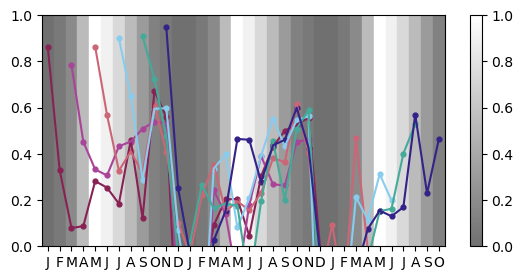

In [19]:
# a. Set colors for initialization months and for background gradient, and the month label (monnam)
cols = ['#882255', '#AA4499', '#CC6677', '#88CCEE', '#44AA99', '#332288']
bgcols2 = ['#FFFFFF', '#F9F9F9', '#F6F6F6', '#F1F1F1', '#ECECEC', '#E6E6E6', '#E0E0E0', '#D9D9D9', '#D2D2D2',
          '#CACACB', '#C3C3C3', '#BBBBBB', '#B3B3B3', '#ABABAB', '#A3A3A3', '#9B9B9B', '#929292', '#8A8A8A',
          '#818181', '#797979', '#707070']

monnam = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 
          'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O']

# b. Prepare the colorbar for the background gradient
bgcols = ['#707070','#FFFFFF']
vals = np.arange(0,1.1,1)
norm = plt.Normalize(vals[0], vals[-1])
cmap = c.LinearSegmentedColormap.from_list('', list(zip(np.array(vals)/vals[-1], bgcols)))

# c. Initialize the figure and prepare the background gradient. Also set the significance line.
fig = plt.figure(figsize=(6.5,3)) 
ax = fig.subplots()
for t in np.arange(0,12):
    bgval = int(20 - np.round(clim_arc[t]/climmax*20, 0))
    ax.axvspan(t - .5, t + .5, color=bgcols2[bgval]);
    ax.axvspan(t + 11.5, t + 12.5, color=bgcols2[bgval]);
    ax.axvspan(t + 23.5, t + 24.5, color=bgcols2[bgval]);

# d. Plot PPP for each initialization month
lim_init = np.zeros(24)
for imno in np.arange(0,6):
    for t in np.arange(0,24):
        tclim = t + imno * 2
        if tclim >= 12:
            tclim = tclim - 12
        if tclim >= 12:
            tclim = tclim - 12
    plt.plot(np.arange(0 + imno*2,24 + imno*2), PPP_arc[imno,:], color = cols[imno]); 
    plt.scatter(np.arange(0 + imno*2,24 + imno*2), PPP_arc[imno,:], color = cols[imno], s= 12)
plt.xticks(np.arange(0,24+2*imno), monnam); plt.xlim(-.5,33.5)
fig.colorbar(ScalarMappable(norm=norm, cmap=cmap))
# plt.xlabel('Month'), plt.ylabel('PPP'); 
plt.ylim(0,1)

# e. Write plot out.
# figdir = '/glade/u/home/cpayne/Projects/PredictPerfect/Figures/PaperFigs/PPP_NPPmean_2030.png';
# plt.savefig(figdir,facecolor='none', dpi = 600);
# # plt.close()


8. Here, I use bootstrapping to investigate why PPP has negative values. I calculate a climatology using 15 random ensemble members and compare variability in the climatology to variability in the perfect model experiment ensembles.

In [92]:
import random

x=random.sample(range(150), 15)
print(x)

dat_clim_boot = np.zeros([15,12,384,320])
for a in np.arange(0,15):
    xx = x[a]
    dat_clim_boot[a,:,:,:] = dat_climt[xx,:,:,:]

[56, 131, 82, 40, 55, 145, 134, 8, 1, 37, 147, 113, 64, 69, 109]


In [93]:
# Calculate PPP for the whole Arctic - logged values
# a. initialize empty arrays
PPP_arc = np.zeros([6,24]);
totarc_sumclim_boot = np.zeros([15,12]);
totarc_meanlogclim_boot = np.zeros([12]); totarc_varlogclim_boot = np.zeros([12]); 

# b. Loop through grid cells. In the Arctic, add climatological NPP by month (taking grid cell area into
#    account). Then find the mean and variance for the log(NPP).
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(areacello_ocn[i,j]) == False:
            for t in np.arange(0,12):
                totarc_sumclim_boot[:,t] = dat_clim_boot[:,t, i, j]*areacello_ocn[i,j] + totarc_sumclim_boot[:,t]
totarc_meanlogclim_boot[:] = np.nanmean(np.log(totarc_sumclim_boot[:,:] + 1e-16), axis = 0)
totarc_varlogclim_boot[:] = np.nanvar(np.log(totarc_sumclim_boot[:,:]+ 1e-16), axis = 0)

# d. Calculate the PPP for each initialization (6) and each month (24). Log variance is calculated using 
#    equations from Campbell (1995). Note that the variance of the climatology is calculated using the 
#    correct month (t is the forecast month, so tclim is calculated to find the actual month).
tarc_varclim_boot = np.zeros([6,24]);
for imno in np.arange(0,6):
    for t in np.arange(0,24):
        tclim = t + imno * 2
        if tclim >= 12:
            tclim = tclim - 12
        if tclim >= 12:
            tclim = tclim - 12
        totarc_varclim_boot = (math.exp(totarc_varlogclim_boot[tclim]) - 1) * (math.exp(2* totarc_meanlogclim_boot[tclim] + totarc_varlogclim_boot[tclim])) #totarc_varlogclim[t]#
        tarc_varclim_boot[imno,t] = totarc_varclim_boot
        

In [94]:
tarc_varclim_boot2 = np.tile(tarc_varclim_boot[0,0:12], reps =3)
print(tarc_varclim_boot2)

[2.31188513e+18 2.18617241e+19 8.13038599e+20 6.53378631e+21
 7.45967390e+21 7.33285749e+21 4.65708489e+21 1.53881642e+21
 4.56331394e+20 6.54023493e+19 5.14807973e+18 1.16163362e+18
 2.31188513e+18 2.18617241e+19 8.13038599e+20 6.53378631e+21
 7.45967390e+21 7.33285749e+21 4.65708489e+21 1.53881642e+21
 4.56331394e+20 6.54023493e+19 5.14807973e+18 1.16163362e+18
 2.31188513e+18 2.18617241e+19 8.13038599e+20 6.53378631e+21
 7.45967390e+21 7.33285749e+21 4.65708489e+21 1.53881642e+21
 4.56331394e+20 6.54023493e+19 5.14807973e+18 1.16163362e+18]


Here, I plot variance for the ensemble members and compare it to the bootstrapped large ensemble-based climatology.

/glade/derecho/scratch/cpayne/tmp/ipykernel_50523/408490380.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(ScalarMappable(norm=norm, cmap=cmap))


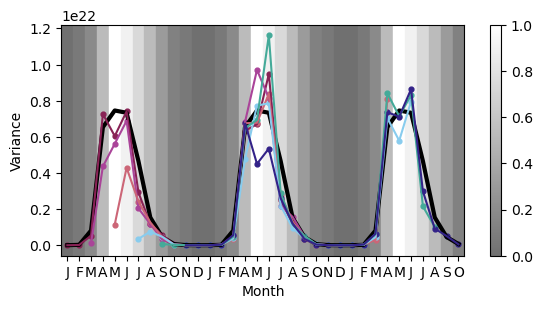

In [95]:
# a. Set colors for initialization months and for background gradient, and the month label (monnam)
cols = ['#882255', '#AA4499', '#CC6677', '#88CCEE', '#44AA99', '#332288']
bgcols2 = ['#FFFFFF', '#F9F9F9', '#F6F6F6', '#F1F1F1', '#ECECEC', '#E6E6E6', '#E0E0E0', '#D9D9D9', '#D2D2D2',
          '#CACACB', '#C3C3C3', '#BBBBBB', '#B3B3B3', '#ABABAB', '#A3A3A3', '#9B9B9B', '#929292', '#8A8A8A',
          '#818181', '#797979', '#707070']

monnam = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 
          'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O']

# b. Prepare the colorbar for the background gradient
bgcols = ['#707070','#FFFFFF']
vals = np.arange(0,1.1,1)
norm = plt.Normalize(vals[0], vals[-1])
cmap = c.LinearSegmentedColormap.from_list('', list(zip(np.array(vals)/vals[-1], bgcols)))

# c. Initialize the figure and prepare the background gradient. Also set the significance line.
fig = plt.figure(figsize=(6.5,3)) 
ax = fig.subplots()
for t in np.arange(0,12):
    bgval = int(20 - np.round(clim_arc[t]/climmax*20, 0))
    ax.axvspan(t - .5, t + .5, color=bgcols2[bgval]);
    ax.axvspan(t + 11.5, t + 12.5, color=bgcols2[bgval]);
    ax.axvspan(t + 23.5, t + 24.5, color=bgcols2[bgval]);

plt.plot(np.arange(0,34), tarc_varclim_boot2[0:34], color = 'black',linewidth =3); 
# d. Plot PPP for each initialization month
lim_init = np.zeros(24)
for imno in np.arange(0,6):
    for t in np.arange(0,24):
        tclim = t + imno * 2
        if tclim >= 12:
            tclim = tclim - 12
        if tclim >= 12:
            tclim = tclim - 12
    plt.plot(np.arange(0 + imno*2,24 + imno*2), tarc_varpme[imno,:], color = cols[imno]); 
    plt.scatter(np.arange(0 + imno*2,24 + imno*2), tarc_varpme[imno,:], color = cols[imno], s= 12)
plt.xticks(np.arange(0,24+2*imno), monnam); plt.xlim(-.5,33.5)
fig.colorbar(ScalarMappable(norm=norm, cmap=cmap))
plt.xlabel('Month'), plt.ylabel('Variance'); 
# plt.ylim(0,1)


Here, I calculate how many PPP values are positive in the most productive months for each initialization month. I use this to statistically compare PPP between the 2010s and the 2030s.

In [109]:
PPPmean_30 = np.zeros([6]); PPPmean_10 = np.zeros([6]);
for imno in np.arange(0,6):
    ct30 = 0; ct10 = 0
    for t in np.arange(0,24):
        tclim = t + imno * 2
        if tclim >= 12:
            tclim = tclim - 12
        if tclim >= 12:
            tclim = tclim - 12
        if tclim >= 4 and tclim <= 6 and PPP_arc_30[imno,t] > 0:
            ct30 = ct30 + 1
            PPPmean_30[imno] = PPP_arc_30[imno,t] + PPPmean_30[imno]
        if tclim >= 4 and tclim <= 6 and PPP_arc_10[imno,t] > 0:
            ct10 = ct10 + 1
            PPPmean_10[imno] = PPP_arc_10[imno,t] + PPPmean_10[imno]
            # if imno == 0:
            #     print(tclim, ct10, PPP_arc_10[imno,t])
    PPPmean_30[imno] = PPPmean_30[imno]/ct30; PPPmean_10[imno] = PPPmean_10[imno]/ct10; 

In [112]:
import scipy.stats as stats
stats.ttest_rel(PPPmean_10, PPPmean_30)

TtestResult(statistic=-7.342269658023584, pvalue=0.0007353457173672577, df=5)

In [87]:
import scipy.stats as stats
stats.ttest_rel(PPPmean_10, PPPmean_30)

TtestResult(statistic=-3.452816293002928, pvalue=0.01818238838055678, df=5)

In [101]:
# for imno in np.arange(0,6):
print(stats.ttest_rel(np.mean(PPP_arc_10,axis=0),np.mean(PPP_arc_30,axis=0)))

TtestResult(statistic=-1.7680502561502796, pvalue=0.09031713501405034, df=23)


In [106]:
PPP_init30 = np.full([6,34], np.nan); PPP_init10 = np.full([6,34], np.nan); 
for imno in np.arange(0,6):
    for t in np.arange(0,24):
        treal = t + imno * 2
        tclim = treal
        if tclim >= 12:
            tclim = tclim - 12
        if tclim >= 12:
            tclim = tclim - 12
        if PPP_arc_10[imno,t] > 0:
            PPP_init10[imno,treal] = PPP_arc_10[imno,t]
        if PPP_arc_30[imno,t] > 0:
            PPP_init30[imno,treal] = PPP_arc_30[imno,t]
        

In [115]:
for t in np.arange(0,34):
    ttest = stats.ttest_rel(PPP_init10[:,t], PPP_init30[:,t])
    if ttest.pvalue < 0.05:
        print(t,np.nanmean(PPP_init10[:,t]), np.nanmean(PPP_init30[:,t]), ttest.pvalue)

14 0.2019659197122267 0.31613545077502464 0.03194240182721445
18 0.2984053338541827 0.4940070286689535 0.006502200954019821
